![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 -  Object Detection </center>
### <center> Object Detection with Anchors </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_ObjectDetection/MainAnchors.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_ObjectDetection/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
#-----------------------------------------------------------#
#-----------------------------------------------------------#
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn    as nn
import torch.optim as optim
import torchinfo

from torch.optim.lr_scheduler import OneCycleLR
#-----------------------------------------------------------#
#-----------------------------------------------------------#
torch.set_printoptions(3, linewidth=120, sci_mode=False)
torch.backends.cudnn.benchmark = True

#### Constants:

In [5]:
IMAGE_SIZE = 100
GRID_SIZE  = 5
LABELS     = ['R', 'G', 'B']

DEVICE     = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#### `RandImage` creates a synthetic image for object detection:

In [6]:
from DeepLearningFramework.AnchorsUtils import RandImage

mI, mBBox = RandImage(IMAGE_SIZE, 3)
mBBox

tensor([[1.000, 2.000, 0.109, 0.350, 0.218, 0.627],
        [1.000, 0.000, 0.670, 0.884, 0.628, 0.231],
        [1.000, 0.000, 0.478, 0.583, 0.624, 0.522]])

#### Plot an image with its bounding boxes:

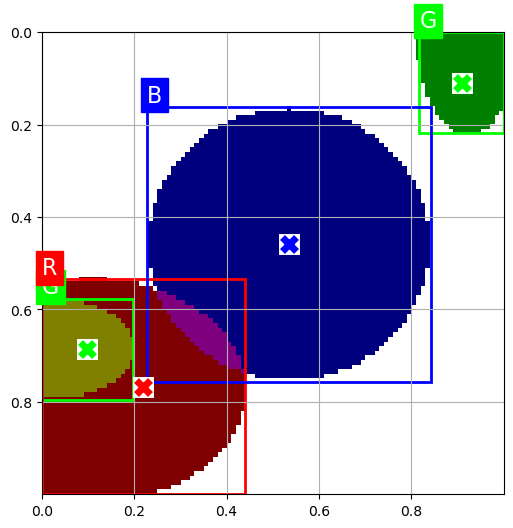

In [7]:
from DeepLearningFramework.AnchorsUtils import PlotImage

nObjects  = np.random.randint(10) + 1
mI, mBBox = RandImage(IMAGE_SIZE, nObjects)

PlotImage(mI, mBBox, LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)
plt.show ()

#### Create synthetic datasets:
Note that `mBBox.shape = (Di, 6)` where `Di` is the number of objects.  
`Di` is different from image to image.

In [8]:
def MakeData(N):
    mX    = torch.empty(N, 3, IMAGE_SIZE, IMAGE_SIZE)
    lBBox = [None] * N
    for ii in range(N):
        nObjects   = np.random.randint(4) + 1
        mXi, mBBox = RandImage(IMAGE_SIZE, nObjects)
        mX   [ii]  = mXi
        lBBox[ii]  = mBBox

    return mX, lBBox
        
nTrain = 10000
nTest  = 1000

mTrainX, lTrainBBox = MakeData(nTrain)
mTestX,  lTestBBox  = MakeData(nTest)

mTrainX.shape, len(lTrainBBox)

(torch.Size([10000, 3, 100, 100]), 10000)

### Anchors:
`mAnchors.shape = (B, 2)`

In [9]:
mAnchors = torch.tensor([[0.30, 0.50],
                         [0.50, 0.30]])

B        = mAnchors.shape[0]

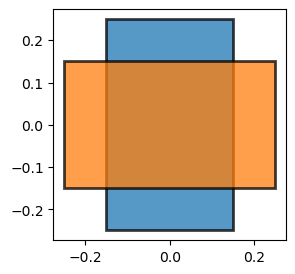

In [10]:
import matplotlib
from   matplotlib.patches import Rectangle
#-----------------------------------------------------------------------------------------------------#
#-----------------------------------------------------------------------------------------------------#
_, ax = plt.subplots(figsize=(3, 3))

cmap = matplotlib.cm.get_cmap('tab10')
for ii in range(B):
    W, H  = mAnchors[ii,:]
    oBBox = Rectangle((-W/2, -H/2), W, H, linewidth=2, edgecolor='k', facecolor=cmap(ii), alpha=.75)
    ax.add_patch(oBBox)

ax.axis('equal')
plt.show()

### `BBox2Target`
This function transforms BBoxes into targets.  
The targets are compared with the network output.

In [11]:
import torchvision.ops as ops

def ComputeAnchorIoU(mXYWH, mAnchors):
    #-- mXYWH   .shape = (D, 4)
    #-- mAnchors.shape = (B, 4)
        
    D         = mXYWH.shape[0]
    B         = mAnchors.shape[0]
    m00WH     = torch.cat([torch.zeros(D, 2), mXYWH[:,2:]], dim=1) #-- (D, 4)
    m00Anchor = torch.cat([torch.zeros(B, 2), mAnchors   ], dim=1) #-- (B, 4)
    mB1       = ops.box_convert(m00WH,     'xywh', 'xyxy')
    mB2       = ops.box_convert(m00Anchor, 'xywh', 'xyxy')
    mIoU      = ops.box_iou(mB1, mB2)                              #-- (D, B)
    
    return mIoU

def BBox2Target(mBBox, mAnchors, gridSize):
    '''
    * Input:
        - mBBox   .shape = (D, 6)
        - mAnchors.shape = (B, 2)
        - mBBox   [ii,:] = [prob | cIdx | x, y, W, H]
        - mAnchors[ii,:] = [W, H]
    * Output:
        - mTarget.shape       = (B, 6, S, S)
        - mTarget[ii,:,jj,kk] = [prob | x, y, log(W), log(H) | cIdx]
    '''
    B       = mAnchors.shape[0]
    D       = mBBox   .shape[0]
    mTarget = torch   .zeros(B, 6, gridSize, gridSize)
    
    if D == 0:
        return mTarget

    #-- Compute IoU between objectes and anchors:
    mXYWH = mBBox[:,2:]
    mIoU  = ComputeAnchorIoU(mXYWH, mAnchors) #-- (D, B)
    vIdx  = torch.argmax(mIoU, dim=1)
    
    #-- Set target for each anchor:
    for bb in range(B):
        mProb  = torch.zeros(1, gridSize, gridSize)
        mLabel = torch.zeros(1, gridSize, gridSize)
        mXYwh  = torch.zeros(4, gridSize, gridSize) #-- w = log(W), h = log(H)

        vIdxB           = vIdx == bb        #-- Objects that correspond to anchor bb
        vP, vLabel      = mBBox[vIdxB,:2].T
        mXYWH           = mBBox[vIdxB,2:] * gridSize
        vX, vY, vW ,vH  = mXYWH.T
        vCx             = vX.floor().long() #-- cell x index
        vCy             = vY.floor().long() #-- cell y index
        vX             -= vCx               #-- cell x
        vY             -= vCy               #-- cell y

        mProb  [0,vCy,vCx] = vP
        mLabel [0,vCy,vCx] = vLabel
        mXYwh  [:,vCy,vCx] = torch.stack([vX, vY, torch.log(vW), torch.log(vH)])
        mTarget[bb]        = torch.cat  ([mProb, mXYwh, mLabel],               )

    return mTarget

mBBox   = lTrainBBox[0]
mTarget = BBox2Target(mBBox, mAnchors, GRID_SIZE)
mTarget.shape

torch.Size([2, 6, 5, 5])

### Define a `Dataset` class
Since the number of targets is different in each image we use a `list` and not a `tensor`.

In [12]:
if False:
    class AnchorObjectDataset(torch.utils.data.Dataset):
        def __init__(self, mX, lBBox, mAnchors, gridSize):
            #-- mX       .shape = (N, C, W, H)
            #-- len(lBBox)      =  N
            #-- lBBox[ii].shape = (Di, 6)
            #-- mAnchors .shape = (B, 2)
            self.mX       = mX
            self.lBBox    = lBBox
            self.mAnchors = mAnchors
            self.gridSize = gridSize

        def __len__(self):
            return self.mX.shape[0]

        def __getitem__(self, idx):
            mXi     = self.mX   [idx]
            mBBox   = self.lBBox[idx]
            mTarget = BBox2Target(mBBox, self.mAnchors, self.gridSize)
            return mXi, mBBox, mTarget

#### Create train and test sets:

In [13]:
from DeepLearningFramework.AnchorsUtils import AnchorObjectDataset

oTrainSet = AnchorObjectDataset(mTrainX, lTrainBBox, mAnchors, GRID_SIZE)
oTestSet  = AnchorObjectDataset(mTestX,  lTestBBox,  mAnchors, GRID_SIZE)

len(oTrainSet), len(oTestSet)

(10000, 1000)

#### Test our dataset code:
`mTarget.shape       = (2, 6, 5, 5)`  
`mTarget[ii,:,jj,kk] = [prob, cIdx, x, y, W, H]`

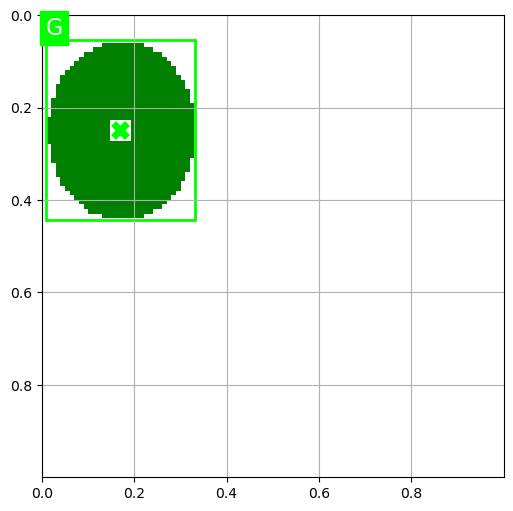

(tensor([[0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]))

In [14]:
idx                = np.random.randint(nTrain)
mX, mBBox, mTarget = oTrainSet[idx]

PlotImage(mX, mBBox, vLabels=LABELS, lColors=np.eye(3))
plt.show()
mTarget[0,0,:,:], mTarget[1,0,:,:]

#### Create a `DataLoader` with its `Collate` function:

In [15]:
if False:
    def AnchorObjectCollate(lBatch):

        lX, lBBox, lTarget = zip(*lBatch)
        mX                 = torch.stack(lX)
        mTarget            = torch.stack(lTarget)

        return mX, lBBox, mTarget

In [16]:
from DeepLearningFramework.Dataset import AnchorObjectCollate

batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=AnchorObjectCollate, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=AnchorObjectCollate, num_workers=2, persistent_workers=True)

mX,       lBBox,      mTarget = next(iter(oTrainDL))
mX.shape, len(lBBox), mTarget.shape

(torch.Size([256, 3, 100, 100]), 256, torch.Size([256, 2, 6, 5, 5]))

#### A simple test:

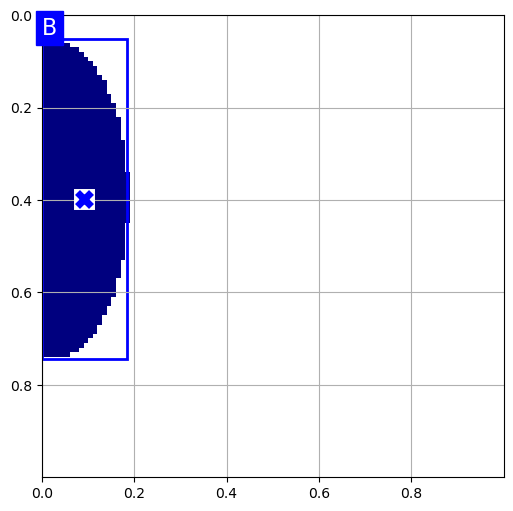

In [17]:
mX, lBBox, mTarget = next(iter(oTrainDL))

PlotImage(mX[0], lBBox[0], vLabels=LABELS, lColors=np.eye(3), gridSize=GRID_SIZE)

### Define the model:
The output shape is: $B \times (5+L) \times S \times S$.  
In our case $B = 2$, $S = 5$, and $L = 3$.  
($L$ is the number of labels)

We use `sigmoid` to make sure $x, y \in [0, 1]$.

In [18]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()

        self.oLeftBranch = nn.Sequential(
            nn.Conv2d(C, C//2, 1, stride=1, padding=0, bias=False), nn.BatchNorm2d(C//2), nn.LeakyReLU(0.1),
            nn.Conv2d(C//2, C, 3, stride=1, padding=1, bias=False), nn.BatchNorm2d(C   ), nn.LeakyReLU(0.1),
        )
        
    def forward(self, mX):
        mOut = self.oLeftBranch(mX) + mX
        return mOut

In [19]:
class Model(nn.Module):
    def __init__(self, B):
        super(Model, self).__init__()

        self.B   = B
        self.oNN = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(3,   32,  5, stride=2, padding=2, bias=False), nn.BatchNorm2d(32 ), nn.ReLU(), nn.Dropout2d(0.2),
            ResBlock(32),                                                                            nn.Dropout2d(0.2),
            ResBlock(32),                                                                            nn.Dropout2d(0.2),
            nn.Conv2d(32,  64,  3, stride=2, padding=1, bias=False), nn.BatchNorm2d(64 ), nn.ReLU(), nn.Dropout2d(0.2),
            ResBlock(64),                                                                            nn.Dropout2d(0.2),
            ResBlock(64),                                                                            nn.Dropout2d(0.2),
            nn.Conv2d(64,  128, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(), nn.Dropout2d(0.2),
            ResBlock(128),                                                                           nn.Dropout2d(0.2),
            ResBlock(128),                                                                           nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout2d(0.2),
            ResBlock(256),                                                                           nn.Dropout2d(0.2),
            ResBlock(256),                                                                           nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, 3, stride=2, padding=2, bias=False), nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout2d(0.2),
            nn.Conv2d(512, B*8, 1, stride=1, padding=0, bias=True ),
    )
        
    def forward(self, mX):
        mOutput = self.oNN(mX)                                 #-- [N, B*8, S, S]
        mOutput = mOutput.view(-1, B, 8, GRID_SIZE, GRID_SIZE) #-- [N, B, 8, S, S]
        
                                        #-- mOutput[ii,bb,:,jj,kk] = [p | x, y, log(W), log(H) | R, G, B]
        mOutput[:,:,1:3,:,:].sigmoid_() #-- makes sure x and y are in [0, 1]
                
        return mOutput
#-------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------------------------------------------------#
#-- Model summary:
mTarget = Model(B)(mX)
mTarget.shape, \
torchinfo.summary(Model(B), mX.shape)

(torch.Size([256, 2, 8, 5, 5]),
 Layer (type:depth-idx)                   Output Shape              Param #
 Model                                    --                        --
 ├─Sequential: 1-1                        [256, 16, 5, 5]           --
 │    └─Identity: 2-1                     [256, 3, 100, 100]        --
 │    └─Conv2d: 2-2                       [256, 32, 50, 50]         2,400
 │    └─BatchNorm2d: 2-3                  [256, 32, 50, 50]         64
 │    └─ReLU: 2-4                         [256, 32, 50, 50]         --
 │    └─Dropout2d: 2-5                    [256, 32, 50, 50]         --
 │    └─ResBlock: 2-6                     [256, 32, 50, 50]         --
 │    │    └─Sequential: 3-1              [256, 32, 50, 50]         5,216
 │    └─Dropout2d: 2-7                    [256, 32, 50, 50]         --
 │    └─ResBlock: 2-8                     [256, 32, 50, 50]         --
 │    │    └─Sequential: 3-2              [256, 32, 50, 50]         5,216
 │    └─Dropout2d: 2-9         

### Exercise - loss function (BCE + MSE + CE):
* Implement the loss function:
$$\ell\left(\hat{\boldsymbol{y}},\boldsymbol{y}\right)=\begin{cases}
\lambda_{\text{BCE}}\cdot\ell_{\text{BCE}}\left(\hat{y}_{\text{detect}},y_{\text{detect}}\right) & y_{\text{detect}}=0\\
\lambda_{\text{BCE}}\cdot\ell_{\text{BCE}}\left(\hat{y}_{\text{detect}},y_{\text{detect}}\right)+\lambda_{\text{MSE}}\cdot\ell_{\text{MSE}}\left(\hat{\boldsymbol{y}}_{\text{bbox}},\boldsymbol{y}_{\text{bbox}}\right)+\lambda_{\text{CE}}\cdot\ell_{\text{CE}}\left(\hat{\boldsymbol{y}}_{\text{label}},\boldsymbol{y}_{\text{label}}\right) & y_{\text{detect}}=1
\end{cases}$$
where $\lambda_{\text{BCE}}\lambda_{\text{BCE}}, \lambda_{\text{MSE}}$ and $\lambda_{\text{CE}}$ are the weights
of each loss.  
* Use:
$$\lambda_{\mathrm{BCE}}=\lambda_{\mathrm{CE}}=\lambda_{\mathrm{MSE}}=1$$

**Hint:** Use the `MainVanillaObjectDetection.ipynb` loss function as a reference.

In [20]:
def Loss_Ex(mOutput, mTarget):
    #-- mOutput.shape       = (N, B, 8, 5, 5)
    #-- mTarget.shape       = (N, B, 6, 5, 5)
    #-- mOutput[ii,bb,:,jj,kk] = [p | x, y, W, H | R, G, B]
    #-- mTarget[ii,bb,:,jj,kk] = [p | x, y, W, H | cIdx]
    
#     ???
#     loss = BCE + MSE + CE
    
#     return loss, BCE.item(), CE.item(), MSE.item()
    return 0, 0, 0, 0

#### Test your implementation:

In [21]:
from DeepLearningFramework.AnchorsUtils import Loss

mTarget = torch.cat([torch.randint(0, 2, (1000, 2, 1, 5, 5)), torch.rand(1000, 2, 4, 5, 5), torch.randint(0, 3, (1000, 2, 1, 5, 5))], dim=2)
mOutput = torch.rand(1000, 2, 8, 5, 5)

loss1   = Loss   (mOutput, mTarget)[0]
loss2   = Loss_Ex(mOutput, mTarget)[0]

if np.abs(loss1 - loss2) < 1e-10:
    print('Success!')
else:
    print('Fail!')

Fail!


### `Epoch`
Since we have not implemented a metric (yet), we will use: `metric = -loss`

In [22]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    vEpochStats = np.zeros(5) #-- (Loss, BCE, CE, MSE, -Loss)
    count       = 0
    nIter       = len(oDataDL)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, _, mTarget) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX      = mX     .to(DEVICE)
        mTarget = mTarget.to(DEVICE)

        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mOut               = oModel(mX)
            loss, BCE, CE, MSE = Loss  (mOut, mTarget)

            #-- Backward:
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate
            
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mOut               = oModel(mX)
                loss, BCE, CE, MSE = Loss  (mOut, mTarget)        

        with torch.no_grad():
            Nb           = mX.shape[0]
            vIterStats   = np.array([loss.item(), BCE, CE, MSE, -loss.item()])
            vEpochStats += Nb * vIterStats
            count       += Nb
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:6.3f}', end='')

    print('', end='\r')
    vEpochStats /= count

    return vEpochStats

In [23]:
Metric = None #-- We will do this later

In [24]:
import time

def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, sModelName='AnchorObjectDetection'):

    TRAIN        = 0
    VAL          = 1
    vLR          = np.full(0,       np.nan)
    mHistory     = np.full((2, 5, nEpochs), np.nan)
    lNames       = ['Loss', 'BCE', 'CE', 'MSE', 'Metric']
    bestMetric   = -float('inf')

    fig, _ = plt.subplots(2, 2, figsize=(12, 6))
    for epoch in range(nEpochs):
        startTime               = time.time()
        mHistory[TRAIN,:,epoch] = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        mHistory[VAL,  :,epoch] = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime               = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch                   :03d}:',   end='')
        print(' | Train loss: '   f'{mHistory[TRAIN,0,epoch] :6.3f}',   end='')
        print(' | Val loss: '     f'{mHistory[VAL,  0,epoch] :6.3f}',   end='')
        print(' | Train Metric: ' f'{mHistory[TRAIN,4,epoch] :6.3f}',   end='')
        print(' | Val Metric: '   f'{mHistory[VAL,  4,epoch] :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime               :6.3f} |', end='')

        valMetric = mHistory[VAL,4,epoch]
        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')
            
        for ii, ax in enumerate(fig.axes):
            ax.cla      ()
            ax.plot     (mHistory[TRAIN, ii], 'b', label='Train')
            ax.plot     (mHistory[VAL,   ii], 'r', label='Validation')
            ax.set_title(lNames[ii])
            ax.grid     ()
            ax.legend   ()

        fig.canvas.draw ()
        plt.tight_layout()
        plt.pause       (1e-4)

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return mHistory

<IPython.core.display.Javascript object>


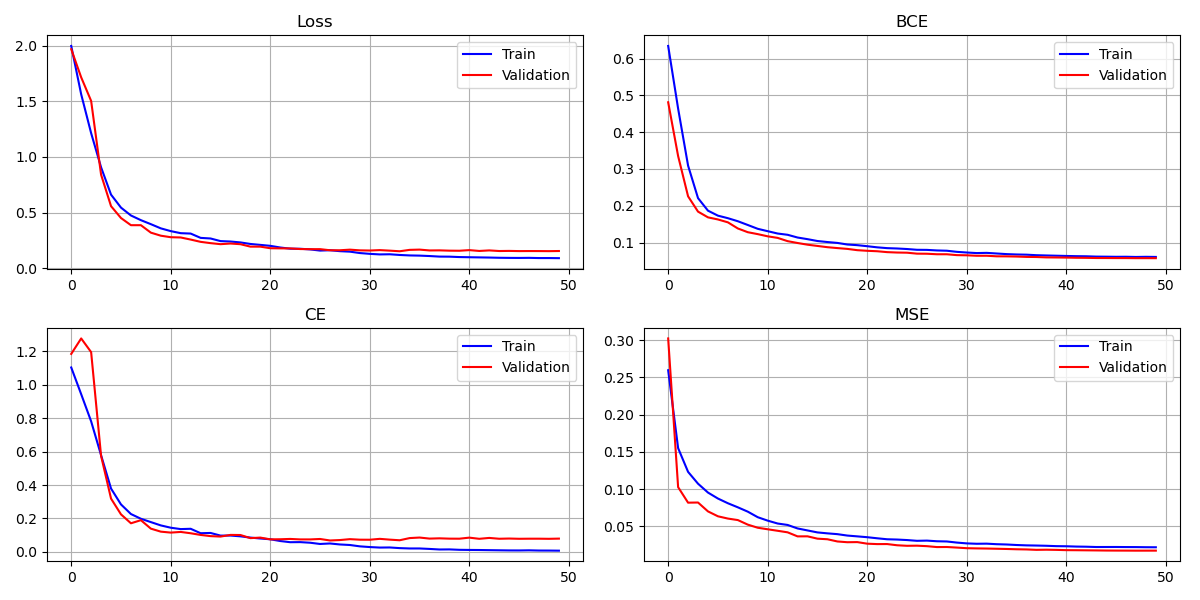

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.998 | Val loss:  1.968 | Train Metric: -1.998 | Val Metric: -1.968 | epoch time:  9.387 | <-- Checkpoint!
Epoch 001: | Train loss:  1.563 | Val loss:  1.715 | Train Metric: -1.563 | Val Metric: -1.715 | epoch time:  4.616 | <-- Checkpoint!
Epoch 002: | Train loss:  1.214 | Val loss:  1.503 | Train Metric: -1.214 | Val Metric: -1.503 | epoch time:  4.744 | <-- Checkpoint!
Epoch 003: | Train loss:  0.906 | Val loss:  0.840 | Train Metric: -0.906 | Val Metric: -0.840 | epoch time:  5.205 | <-- Checkpoint!
Epoch 004: | Train loss:  0.661 | Val loss:  0.557 | Train Metric: -0.661 | Val Metric: -0.557 | epoch time:  4.799 | <-- Checkpoint!
Epoch 005: | Train loss:  0.544 | Val loss:  0.450 | Train Metric: -0.544 | Val Metric: -0.450 | epoch time:  4.871 | <-- Checkpoint!
Epoch 006: | Train loss:  0.473 | Val loss:  0.386 | Train Metric: -0.473 |

In [25]:
%matplotlib notebook

nEpochs    = 50
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      (B).to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=4e-3)
oScheduler = OneCycleLR (oOptim, max_lr=1e-3, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler)

In [26]:
#-- Load best model (early stopping):
# oModel.load_state_dict(torch.load('./AnchorModel_v1.pt'))
# oModel.train(False);

#### Output to target:
* Apply `sigmoid` on detection probability.  
* Apply `argmax` on classification.

In [35]:
def Output2Target(mOutput):
    #-- mOutput.shape          = (N, B, 8, 5, 5)
    #-- mOutput[ii,bb,:,jj,kk] = [p | x, y, log(W), log(H) | R, G, B]
    
    mProb  = torch.sigmoid(mOutput[:,:,[0],:,:])
    mBBox  =               mOutput[:,:,1:5,:,:]
    mLabel = torch.argmax (mOutput[:,:,5:, :,:], dim=2, keepdims=True)
    
    mTarget = torch.cat([mProb, mBBox, mLabel], dim=2)
    return mTarget

#### Target to BBox:
* Transform each cell in the target grid ($S \times S$) into a BBox.
* Scale back the XYWH position of the BBox
* Apply `exp_` to the width and height.

In [36]:
def Target2BBox(mTarget):
    '''
    * Input:
        - mTarget.shape          = (N, B, 6, S, S)
        - mTarget[ii,bb,:,jj,kk] = [p | x, y, log(W), log(H) | cIdx]
    * Output:
        - mBBox.shape    = (N, B*S*S, 6)
        - mBBox[ii,jj,:] = [p | cIdx | x, y, W, H]
    '''
    v       = torch.arange(GRID_SIZE, device=mTarget.device)
    XX, YY  = torch.meshgrid(v, v, indexing='xy')
    
    mProb  = mTarget[:,:,[0],:,:]
    mXYWH  = mTarget[:,:,1:5,:,:].clone()
    mLabel = mTarget[:,:,[5],:,:]
    
    mXYWH[:,:,0,  :,:] += XX[None,None,:,:]
    mXYWH[:,:,1,  :,:] += YY[None,None,:,:]
    mXYWH[:,:,2:4,:,:].exp_()
    mXYWH              /= GRID_SIZE
    
    B     = mTarget.shape[1]
    mBBox = torch.cat([mProb, mLabel, mXYWH], dim=2)                  #-- mBBox.shape = (N, B, 6, 5, 5)
    mBBox = mBBox.permute(0,1,3,4,2).reshape(-1, B * GRID_SIZE**2, 6) #-- mBBox.shape = (N, B*25, 6)
        
    return mBBox

#### Test model:

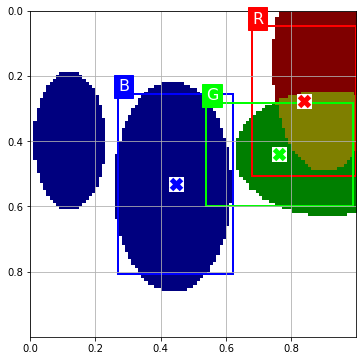

In [46]:
%matplotlib inline

mXi, mBBox, mTarget = oTestSet[np.random.randint(nTest)]
with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))

mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred).cpu()[0]
vIdx        = mBBoxPred[:,0] > 0.5 #-- take only prediciton with prob > 0.5

PlotImage(mXi, mBBoxPred[vIdx], vLabels=LABELS, lColors=np.eye(3))
plt.show ()

#### Test two objects in the same cell:

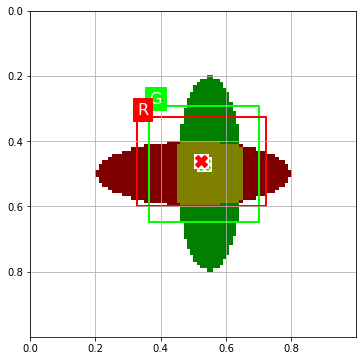

In [38]:
from DeepLearningFramework.AnchorsUtils import CreateImage

mXi, mBBox = CreateImage(IMAGE_SIZE, np.array([.5, .55]), [.5, .5], [.3, .1], [.1, .3], [0, 1])

with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))

mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred).cpu()[0]
vIdx        = mBBoxPred[:,0] > 0.5

PlotImage(mXi, mBBoxPred[vIdx], vLabels=LABELS, lColors=np.eye(3))
plt.show ()

#### View all predictions:

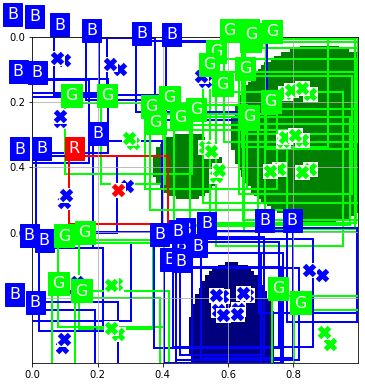

In [39]:
mXi, mBBox, mTarget = oTestSet[np.random.randint(nTest)]

with torch.no_grad():
    mOutput = oModel(mXi[None].to(DEVICE))
    
mTargetPred = Output2Target(mOutput)
mBBoxPred   = Target2BBox  (mTargetPred).cpu()[0]

PlotImage(mXi, mBBoxPred, vLabels=LABELS, lColors=np.eye(3))
plt.show ()

### NMS:

In [40]:
def NMS(mBBox, IoUThreshold=0.5, pThreshold=0.1):
    #-- mBBox.shape    = (N, D, 6)
    #-- mBBox[ii,jj,:] = [prob | cIdx | x, y, W, H]
    mBBoxCPU = mBBox.cpu() #-- GPU is slower
    N        = mBBox.shape[0]
    lBBox    = [torch.empty(0, 6)] * N
    for ii in range(N):
        vIdx = mBBoxCPU[ii,:,0] > pThreshold
        if torch.any(vIdx):
            mBBc      = mBBoxCPU[ii,vIdx]
            vIdx      = ops.batched_nms(ops.box_convert(mBBc[:,2:], 'cxcywh', 'xyxy'), mBBc[:,0], mBBc[:,1], IoUThreshold)
            lBBox[ii] = mBBc[vIdx]

    return lBBox

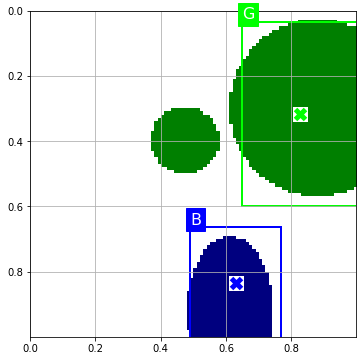

In [41]:
mNMS = NMS(mBBoxPred[None], 0.5, 0.25)[0]

PlotImage(mXi, mNMS, vLabels=LABELS, lColors=np.eye(3))
plt.show ()

In [34]:
# def Loss_Ex(mOutput, mTarget):
#     #-- mOutput.shape       = (N, B, 8, 5, 5)
#     #-- mTarget.shape       = (N, B, 6, 5, 5)
#     #-- mOutput[ii,bb,:,jj,kk] = [p | x, y, W, H | R, G, B]
#     #-- mTarget[ii,bb,:,jj,kk] = [p | x, y, W, H | cIdx]
#     mProb      = mTarget[:,:,0,:,:]
#     mMask      = mProb == 1
    
#     mBBox      = mTarget[:,:,1:5,:,:].permute(0,1,3,4,2)[mMask] #-- mBBox .shape = (T, 4)
#     vLabel     = mTarget[:,:,5  ,:,:].long()            [mMask] #-- vLabel.shape = (T)
    
#     mProbPred  = mOutput[:,:,0,  :,:] 
#     mBBoxPred  = mOutput[:,:,1:5,:,:].permute(0,1,3,4,2)[mMask]  #-- mBBoxPred .shape = (T, 4)
#     mLabelPred = mOutput[:,:,5:, :,:].permute(0,1,3,4,2)[mMask]  #-- mLabelPred.shape = (T, L)
    
#     BCE = nn.BCEWithLogitsLoss()(mProbPred,  mProb)
#     MSE = nn.MSELoss          ()(mBBoxPred,  mBBox)
#     CE  = nn.CrossEntropyLoss ()(mLabelPred, vLabel)
    
#     loss = BCE + MSE + CE
    
#     return loss, BCE.item(), CE.item(), MSE.item()